🔄 Đang load dữ liệu...
Phân bố lớp: [ 48437. 103825.   8081.   2957.    652.   1183.    468.  12126.   3804.
    850.    636.]
✅ Dữ liệu đã được load. Bắt đầu xây dựng mô hình LSTM...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 35, 64)            16896     
                                                                 
 batch_normalization (BatchN  (None, 35, 64)           256       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 35, 128)           98816     
                                                                 
 batch_normalization_1 (Batc  (None, 35, 128)          512       
 hNormalization)                                                 
                                                                 
 lst

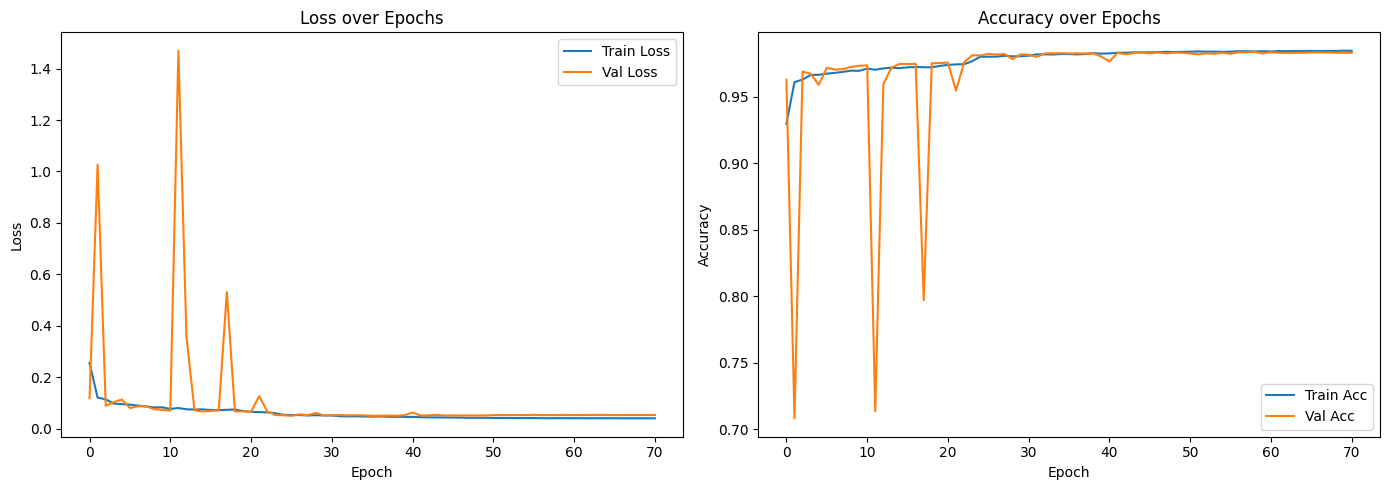

🔎 Dự đoán trên tập test...
205/205 [==============================] - 2s 7ms/step
📊 Ma trận nhầm lẫn:


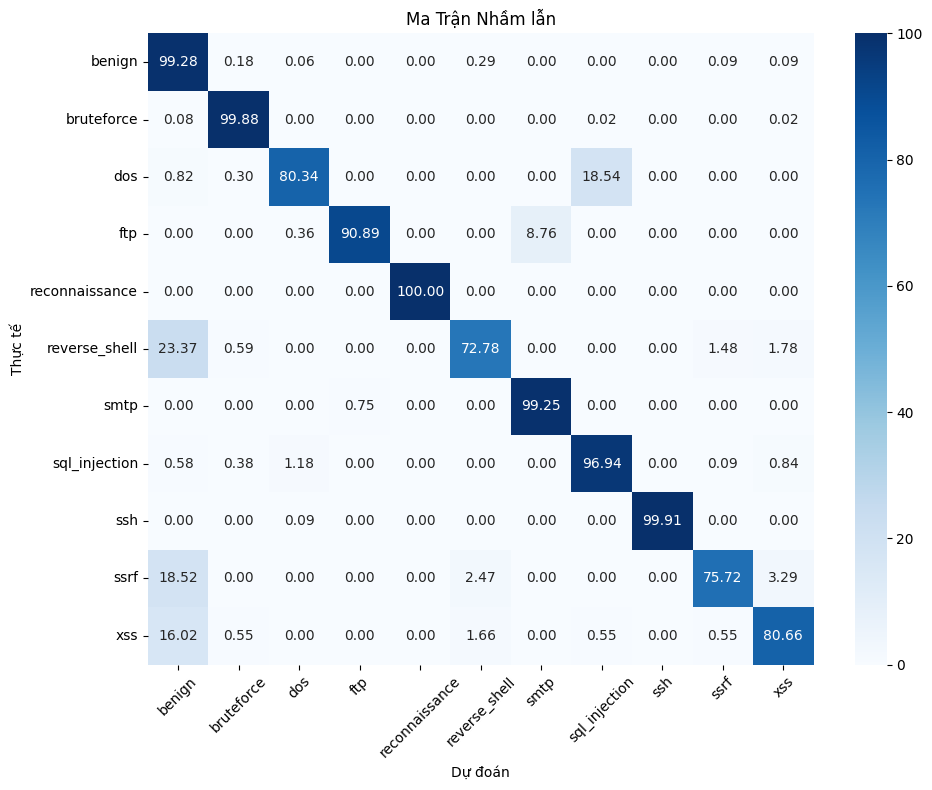


📋 Classification Report:
                precision    recall  f1-score   support

        benign     0.9845    0.9928    0.9886     13840
    bruteforce     0.9984    0.9988    0.9986     29666
           dos     0.9722    0.8034    0.8798      2309
           ftp     0.9987    0.9089    0.9517       845
reconnaissance     1.0000    1.0000    1.0000       186
 reverse_shell     0.8339    0.7278    0.7773       338
          smtp     0.6408    0.9925    0.7788       133
 sql_injection     0.8856    0.9694    0.9256      3465
           ssh     1.0000    0.9991    0.9995      1087
          ssrf     0.8932    0.7572    0.8196       243
           xss     0.7019    0.8066    0.7506       181

      accuracy                         0.9816     52293
     macro avg     0.9008    0.9051    0.8973     52293
  weighted avg     0.9826    0.9816    0.9815     52293


📈 Precision-Recall từng lớp:


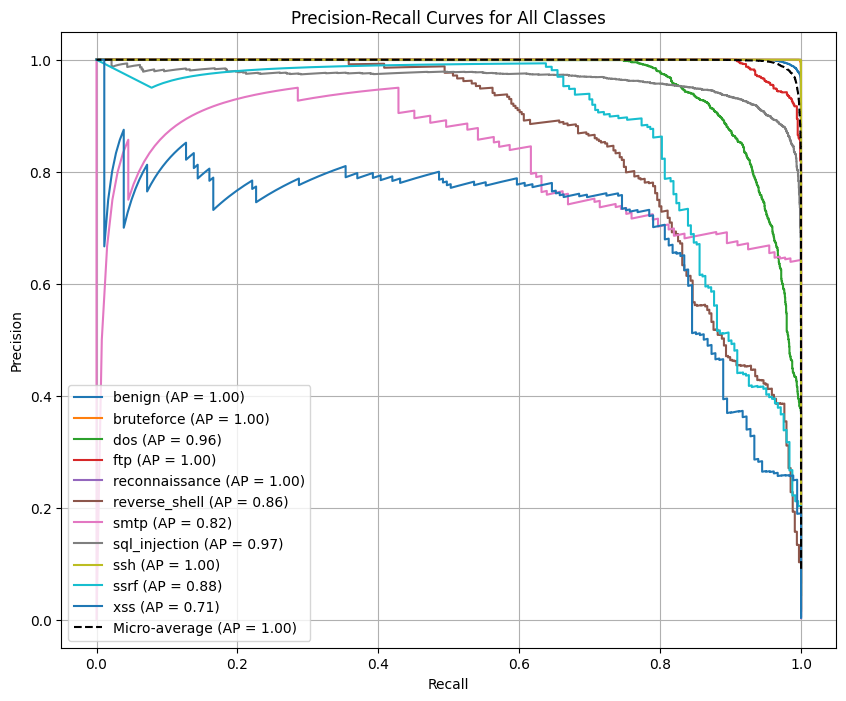


📊 F1-Score từng lớp:


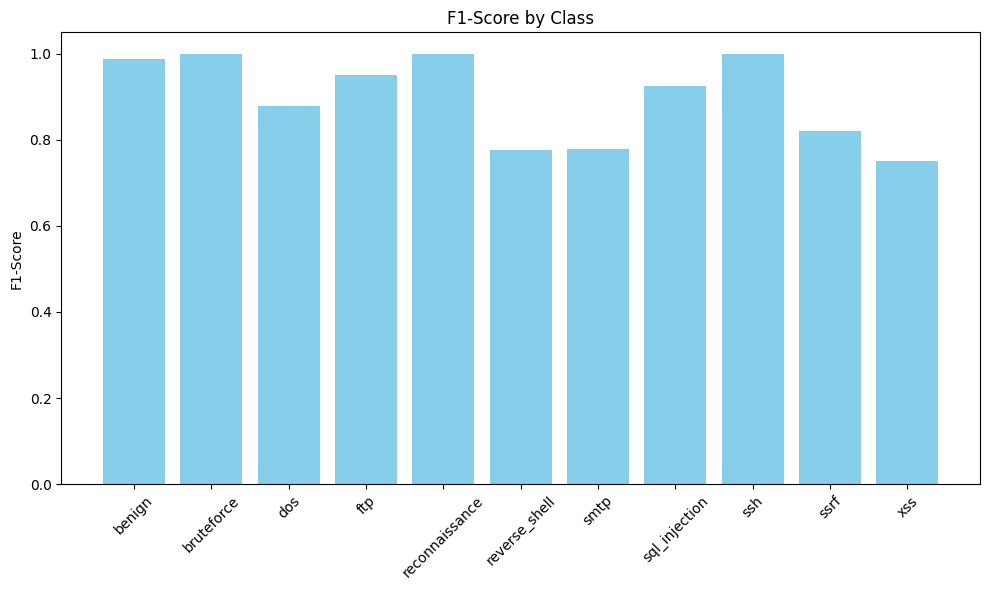


✅ Test Accuracy: 0.9816 - Test Loss: 0.0514
💾 Mô hình đã được lưu vào: lstm_webids23_model.h5


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler

# ==== 1. Tên lớp gộp ====
class_names = [
    'benign', 'bruteforce', 'dos', 'ftp', 'reconnaissance',
    'reverse_shell', 'smtp', 'sql_injection', 'ssh', 'ssrf', 'xss'
]

# ==== 2. Hàm reshape an toàn ====
def safe_reshape(X, n_features=35):
    if len(X.shape) == 1:
        assert X.size % n_features == 0, "Tổng phần tử không chia hết cho số đặc trưng"
        X = X.reshape(-1, n_features)
    elif X.shape[1] != n_features:
        raise ValueError(f"Số đặc trưng không đúng. Mong đợi {n_features}, nhưng nhận được {X.shape[1]}")
    return X.reshape(-1, n_features, 1)

# ==== 3. Load và xử lý dữ liệu ====
def load_data(data_path):
    X_train = np.load(os.path.join(data_path, 'X_train.npy'))
    y_train = np.load(os.path.join(data_path, 'y_train.npy'))
    X_val   = np.load(os.path.join(data_path, 'X_val.npy'))
    y_val   = np.load(os.path.join(data_path, 'y_val.npy'))
    X_test  = np.load(os.path.join(data_path, 'X_test.npy'))
    y_test  = np.load(os.path.join(data_path, 'y_test.npy'))

    # Kiểm tra NaN hoặc Inf
    def check_data(X, name="Data"):
        if np.any(np.isnan(X)) or np.any(np.isinf(X)):
            raise ValueError(f"{name} contains NaN or Inf values")
    check_data(X_train, "X_train")
    check_data(X_val, "X_val")
    check_data(X_test, "X_test")

    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[1])).reshape(X_val.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[1])).reshape(X_test.shape)

    X_train = safe_reshape(X_train, n_features=35)
    X_val   = safe_reshape(X_val, n_features=35)
    X_test  = safe_reshape(X_test, n_features=35)

    print("Phân bố lớp:", np.sum(y_train, axis=0))
    return X_train, y_train, X_val, y_val, X_test, y_test

# ==== 4. Xây dựng mô hình LSTM ====
def build_lstm_model(input_shape=(35, 1), num_classes=11):
    model = Sequential()
    # Tầng LSTM đầu tiên
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())
    
    # Tầng LSTM thứ hai
    model.add(LSTM(128, return_sequences=True))
    model.add(BatchNormalization())
    
    # Tầng LSTM thứ ba
    model.add(LSTM(256))
    model.add(BatchNormalization())
    
    # Tầng Dense
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])
    return model

# ==== 5. Biểu đồ training ====
def plot_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

    plt.tight_layout()
    plt.show()

# ==== 6. Ma trận nhầm lẫn ====
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_percent = np.round(cm_percent * 100, 2)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title('Ma Trận Nhầm lẫn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ==== 7. Precision-Recall ==== 
def plot_precision_recall(y_true_onehot, y_pred_probs, class_names):
    precision, recall, ap_score = dict(), dict(), dict()
    n_classes = y_true_onehot.shape[1]

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        ap_score[i] = average_precision_score(y_true_onehot[:, i], y_pred_probs[:, i])
        plt.plot(recall[i], precision[i], 
                 label=f"{class_names[i]} (AP = {ap_score[i]:.2f})")

    # Micro-average (tổng hợp toàn bộ)
    precision_micro, recall_micro, _ = precision_recall_curve(y_true_onehot.ravel(), y_pred_probs.ravel())
    ap_micro = average_precision_score(y_true_onehot, y_pred_probs, average="micro")
    plt.plot(recall_micro, precision_micro,
             label=f"Micro-average (AP = {ap_micro:.2f})", color='black', linestyle='--')

    plt.title("Precision-Recall Curves for All Classes")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

# ==== 8. Biểu đồ F1-score ====
def plot_f1_scores(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    f1_scores = [report[cls]['f1-score'] for cls in class_names]
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, f1_scores, color='skyblue')
    plt.xticks(rotation=45)
    plt.ylabel('F1-Score')
    plt.title('F1-Score by Class')
    plt.tight_layout()
    plt.show()

# ==== 9. Main pipeline ====
def main():
    data_path = r'D:/webids23_processed_unbalanced/'
    print("🔄 Đang load dữ liệu...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_path)

    print("✅ Dữ liệu đã được load. Bắt đầu xây dựng mô hình LSTM...")
    model = build_lstm_model()

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=35, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_accuracy')
    ]
    model.summary()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=128,
        callbacks=callbacks,
        verbose=1
    )

    print("✅ Huấn luyện xong. Hiển thị biểu đồ...")
    plot_history(history)

    print("🔎 Dự đoán trên tập test...")
    y_pred_probs = model.predict(X_test, batch_size=256)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("📊 Ma trận nhầm lẫn:")
    plot_confusion_matrix(y_true, y_pred, class_names)

    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    print("\n📈 Precision-Recall từng lớp:")
    plot_precision_recall(y_test, y_pred_probs, class_names)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("\n📊 F1-Score từng lớp:")
    plot_f1_scores(y_true, y_pred, class_names)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ Test Accuracy: {test_acc:.4f} - Test Loss: {test_loss:.4f}")

    model.save("lstm_webids23_model_unbalance.h5")
    print("💾 Mô hình đã được lưu vào: lstm_webids23_model.h5")

# ==== 10. Chạy chương trình ====
if __name__ == "__main__":
    main()